# Series Prediction




In [1]:
import pandas as pd
import pandas

import matplotlib.pyplot as plt

import os

import numpy as np
import numpy
np.random.seed(42)

import seaborn as sns
import seaborn

import sklearn
import sklearn as sk

import copy
from collections import OrderedDict
%matplotlib inline

import seaborn
import seaborn as sns

### Data engineering

In [2]:
data_static = pd.read_csv('raw_data/Static.csv', ';').drop('CLIENT_ID', axis=1)
data_repay  = pd.read_csv('raw_data/Repayments.csv', ';')

In [3]:
group = data_repay.groupby('CONTRACT_ID')

keys, sum_scheduled, sum_actual, avg_scheduled, avg_actual = [], [], [], [], []
last_actual, prelast_actual, prepre_actual = [], [], []

for key, df in group:
    keys            += df['CONTRACT_ID'].tolist()
    sum_scheduled   += df['REPAYMENT_SCHEDULED'].cumsum().tolist()
    sum_actual      += (df['REPAYMENT_ACTUAL'].cumsum() - df['REPAYMENT_SCHEDULED']).tolist()
    mean_act = []
    
    last_pair = [0, 0, 0]
    for item in df['REPAYMENT_ACTUAL']:
        last_actual.append(last_pair[-1])
        prelast_actual.append(last_pair[-2])
        prepre_actual.append(last_pair[-3])
        last_pair.append(item)

        
    
    cnt = 0
    for item in (df['REPAYMENT_ACTUAL'].cumsum() - df['REPAYMENT_SCHEDULED']).tolist():
        if cnt == 0:
            value = 0
        else:
            value = item / cnt
        mean_act.append(value)
        cnt += 1
    mean_sch = []
    cnt = 0
    for item in df['REPAYMENT_SCHEDULED'].cumsum().tolist():
        cnt += 1
        mean_sch.append(item / cnt)
    avg_scheduled += mean_sch
    avg_actual += mean_act

data_repay['CUMSUM_REPAYMENT_SCHEDULED'] = sum_scheduled
data_repay['CUMSUM_REPAYMENT_ACTUAL']    = sum_actual
data_repay['AVG_REPAYMENT_SCHEDULED']    = avg_scheduled
data_repay['AVG_REPAYMENT_ACTUAL']       = avg_actual
data_repay['LAST_ACTUAL'] = last_actual
data_repay['PRELAST_ACTUAL'] = prelast_actual
data_repay['PREPRE_ACTUAL'] = prepre_actual

In [4]:
data_join = pd.merge(data_static, data_repay, on='CONTRACT_ID')
data_join['BEFORE_GRACE']      = data_join['PAYMENT_TO_INCOME'] / data_join['LOAN_TO_INCOME'] * 100
data_join['PERCENT_ACTUAL']    = data_join['REPAYMENT_ACTUAL']  / data_join['CONTRACT_SUM']   * 100
data_join['PERCENT_SCHEDULED'] = data_join['REPAYMENT_SCHEDULED'] / data_join['CONTRACT_SUM'] * 100
data_join['CUMSUM_PERCENT_ACTUAL']    = data_join['CUMSUM_REPAYMENT_ACTUAL']    / data_join['CONTRACT_SUM'] * 100
data_join['CUMSUM_PERCENT_SCHEDULED'] = data_join['CUMSUM_REPAYMENT_SCHEDULED'] / data_join['CONTRACT_SUM'] * 100
data_join['AVG_PERCENT_ACTUAL']    = data_join['AVG_REPAYMENT_ACTUAL']    / data_join['CONTRACT_SUM'] * 100
data_join['AVG_PERCENT_SCHEDULED'] = data_join['AVG_REPAYMENT_SCHEDULED'] / data_join['CONTRACT_SUM'] * 100
data_join['GRACE_ON'] = 1 * np.array(data_join['PERIOD_ID'] <= data_join['GRACE_PERIOD']) 
data_join['LAST_PERCENT_ACTUAL'] = data_join['LAST_ACTUAL'] / data_join['CONTRACT_SUM']
data_join['PRELAST_PERCENT_ACTUAL'] = data_join['PRELAST_ACTUAL'] / data_join['CONTRACT_SUM']
data_join['PREPRE_PERCENT_ACTUAL']  = data_join['PREPRE_ACTUAL']  / data_join['CONTRACT_SUM']

In [5]:
data_join['RATIO_10'] = 1 * np.array(data_join['LOAN_TO_INCOME'] >= 10)
data_join['RATIO_20'] = 1 * np.array(data_join['LOAN_TO_INCOME'] >= 20)
data_join['RATIO_30'] = 1 * np.array(data_join['LOAN_TO_INCOME'] >= 30)
data_join['RATIO_40'] = 1 * np.array(data_join['LOAN_TO_INCOME'] >= 40)

In [6]:
# Adding feature: is grace constant by @Artsem.

is_grace_constant = []
for key, df in data_join.groupby('CONTRACT_ID'):
    df_grace_on = np.array(df['GRACE_ON'])
    check_vals  = np.array(df['REPAYMENT_ACTUAL'])
    grace_values = set()    
    for on, val in zip(df_grace_on, check_vals):
        if on == 1:
            grace_values.add(val)
    append = np.zeros_like(check_vals)
    if len(grace_values) < 2:
        append += 1
    is_grace_constant += append.tolist()

data_join['IS_GRACE_CONSTANT'] = np.array(is_grace_constant)

In [7]:
contracts = np.array(data_static['CONTRACT_ID'].tolist())
shuffled  = copy.deepcopy(contracts)

length    = contracts.shape[0]
RATIO     = 0.1

test_contracts  = shuffled[:int(length * RATIO)].tolist()
train_contracts = shuffled[int(length * RATIO):].tolist()

data_learn = data_join.dropna(axis=0)

data_train = data_learn[data_learn['CONTRACT_ID'].isin(train_contracts)]
data_test  = data_learn[data_learn['CONTRACT_ID'].isin( test_contracts)]

if not os.path.exists('data'):
    os.makedirs('data')
if not os.path.exists('data/train_series.csv') or not os.path.exists('data/test_series.csv'):
    data_train.to_csv('data/train_series.csv')
    data_test.to_csv('data/test_series.csv')
if not os.path.exists('data/all_series_with_na.csv'):
    data_join.to_csv('data/all_series_with_na.csv')

In [8]:
data_train = pd.read_csv('data/train_series.csv').drop("Unnamed: 0", axis=1)
data_test  = pd.read_csv('data/test_series.csv' ).drop("Unnamed: 0", axis=1)
data_learn = pd.read_csv('data/all_series_with_na.csv').drop("Unnamed: 0", axis=1)

### Baseline and Result

Result to complete: Series + Scheduled (if known).

Result for new item: Series (by the feature profile) + Flask Server.

Baseline: copy the scheduled.

In [9]:
# Method Prototype (for single contract).
class IFiller(object):
    def fill_series(X_feats, y_ans, regressor): 
        ''' This is for single fixed user. 
        y_ans either None or has values and nans to be completed.
        returns series for the user '''
        raise NotImplemented
        

## Metrics 


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, explained_variance_score
# y_true, y_pred

def print_metrics(y_true, y_pred):
    for name, metric in zip(["MAE", "MSE", "MAXERR", "EXPVAR"], [
            mean_absolute_error, mean_squared_error, max_error, explained_variance_score]):
        print(name, metric(y_true, y_pred))
        
print('IN DTK')
print_metrics(data_test['REPAYMENT_ACTUAL'], data_test['REPAYMENT_SCHEDULED'])

print('\nIN PERCENT')
print_metrics(data_test['PERCENT_ACTUAL'], data_test['PERCENT_SCHEDULED'])

IN DTK
MAE 24.118156398104265
MSE 12600.13526162717
MAXERR 3295.17
EXPVAR 0.018060973305256467

IN PERCENT
MAE 2.072682127837031
MSE 60.05356126191587
MAXERR 98.80957922174642
EXPVAR 0.04187262424442051


### 1. Next Month  + Predict Percentage + Accumulated Behavior + Schedule Usage.

- Random Forest Regression.
- Linear Regression.
- Lasso.
- NN Regression (sklearn).
- Boost regression.

In [11]:
drop_list = ["PERCENT_ACTUAL", "REPAYMENT_ACTUAL", 'CONTRACT_ID']

data_train = pd.read_csv('data/train_series.csv').drop("Unnamed: 0", axis=1)
X_train = data_train.drop(drop_list, axis=1)
y_train = data_train['PERCENT_ACTUAL']

data_test  = pd.read_csv('data/test_series.csv' ).drop("Unnamed: 0", axis=1)
X_test = data_test.drop(drop_list, axis=1)
y_test = data_test  ['PERCENT_ACTUAL']

X_train['GENDER'] = 1 * np.array(X_train['GENDER'] == 'M')
X_test ['GENDER'] = 1 * np.array(X_test ['GENDER'] == 'M')

In [12]:
from sklearn.preprocessing import StandardScaler

drop_reg = [
    'PRELAST_ACTUAL', 'LAST_ACTUAL', 'PREPRE_ACTUAL', 'REPAYMENT_SCHEDULED',
    'AVG_REPAYMENT_ACTUAL', 'AVG_REPAYMENT_SCHEDULED', 
    'CUMSUM_REPAYMENT_ACTUAL', 'CUMSUM_REPAYMENT_SCHEDULED'
]

scaler = StandardScaler()
scaler.fit(X_train.drop(columns=drop_reg, axis=1))
X_train_reg = scaler.transform(X_train.drop(drop_reg, axis=1))
X_test_reg = scaler.transform(X_test.drop(drop_reg, axis=1))

#### KNN Regression

In [13]:
from sklearn.neighbors import KNeighborsRegressor
est = KNeighborsRegressor(n_neighbors=15)
est.fit(X=X_train_reg, y=y_train)
y_pred = est.predict(X_test_reg)
print("KNN, IN PERCENT")
print_metrics(y_test, y_pred)

KNN, IN PERCENT
MAE 2.265384619760728
MSE 44.71759132230355
MAXERR 91.11346496093701
EXPVAR 0.26770902058725965


#### SVR

In [14]:
from sklearn.svm import SVR
est = SVR(C=10.0, gamma='auto')
est.fit(X_train_reg, y_train)
y_pred = est.predict(X_test_reg)
print("SVR, IN PERCENT")
print_metrics(y_test, y_pred)

SVR, IN PERCENT
MAE 1.676262387351723
MSE 40.86939823433517
MAXERR 94.56385223295682
EXPVAR 0.3332248545800398


#### MLP Regression

In [15]:
from sklearn.neural_network import MLPRegressor
est = MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=10000, alpha=0.01)
est.fit(X_train, y_train)
y_pred = est.predict(X_test)
print("MLP, IN PERCENT")
print_metrics(y_test, y_pred)

MLP, IN PERCENT
MAE 2.038739328548343
MSE 27.759130117735904
MAXERR 86.33490546580573
EXPVAR 0.552320149357244


#### Gradient Boosting Regressor

In [16]:
import xgboost
model = xgboost.XGBRegressor(               
                 learning_rate=0.01,
                 max_depth=4,
                 n_estimators=500,                                                                    
                 reg_alpha=0.5,
                 reg_lambda=0.45,
                 seed=42) 
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print_metrics(y_test, y_pred)

[10:40:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/work/Library/Python/3.7/lib/python/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/work/Library/Python/3.7/lib/python/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


MAE 1.9170863483648033
MSE 26.204433299192875
MAXERR 72.37043956230114
EXPVAR 0.5731180173616004


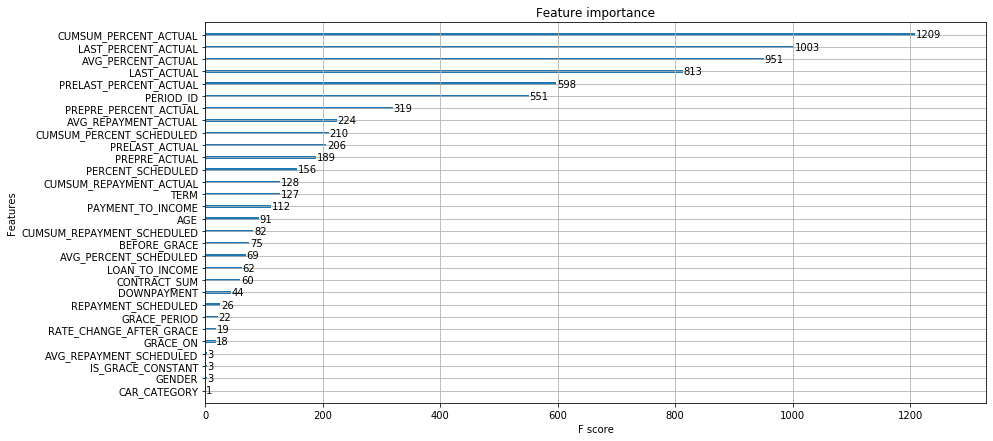

In [17]:
from xgboost import plot_importance
plt.rcParams["figure.figsize"] = (14, 7)
plot_importance(model, height=0.2)

#### Random Forest

In [18]:
from sklearn.ensemble import RandomForestRegressor

est_rf = RandomForestRegressor(n_estimators=300, max_depth=40, random_state=42, min_samples_leaf=10)
est_rf.fit(X_train, y_train)
y_pred = est_rf.predict(X_test)
print("RF, IN PERCENT")
print_metrics(y_test, y_pred)

RF, IN PERCENT
MAE 1.5176712631746438
MSE 23.00037147579106
MAXERR 72.74174394963381
EXPVAR 0.6239427473610623


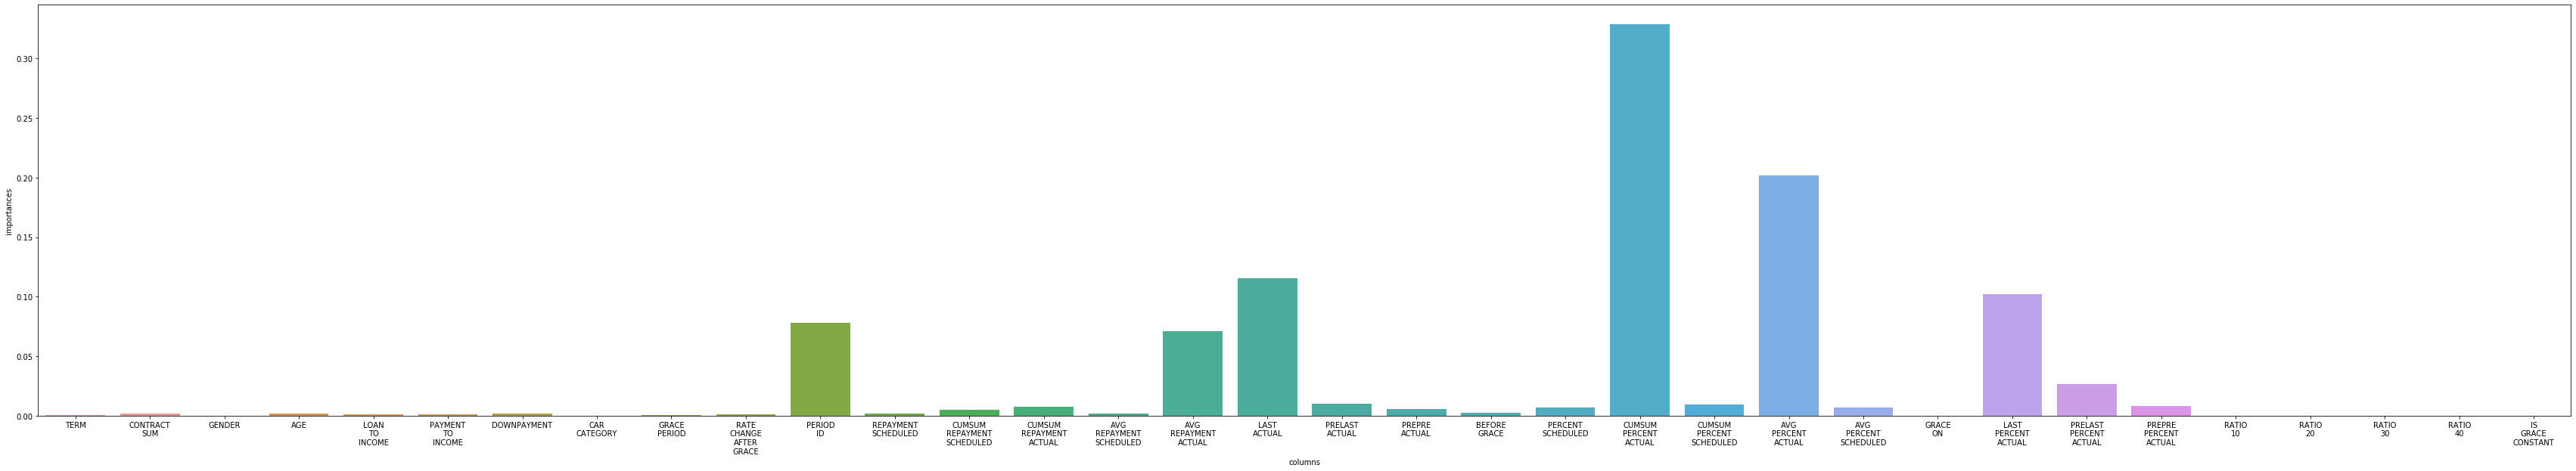

In [19]:
cols = copy.deepcopy(X_train.columns).tolist()
for idx in range(len(cols)):
    cols[idx] = cols[idx].replace("_", "\n")
df = pd.DataFrame.from_dict({
    'importances' : est_rf.feature_importances_,
    'columns'     : cols
})
plt.figure(figsize=(60,10))
sns.barplot(data=df, x='columns', y='importances')

#### Ridge Regression

In [20]:
from sklearn.linear_model import Ridge


est = Ridge(alpha=0.1)
est.fit(X_train_reg, y_train)
y_pred = est.predict(X_test_reg)
print("RIDGE, IN PERCENT")
print_metrics(y_test, y_pred)

RIDGE, IN PERCENT
MAE 4.580606973412578
MSE 71.7627435632422
MAXERR 69.23453309745645
EXPVAR -0.17226211296779192


#### HuberRegressor

In [21]:
from sklearn.linear_model import HuberRegressor

est = HuberRegressor(alpha=0.1)
est.fit(X_train_reg, y_train)
y_pred = est.predict(X_test_reg)
print("HUBER, IN PERCENT")
print_metrics(y_test, y_pred)

HUBER, IN PERCENT
MAE 2.821764324513129
MSE 54.336037887130594
MAXERR 87.34925179769446
EXPVAR 0.1138236171572985


#### Bayesian Ridge

In [22]:
from sklearn.linear_model import BayesianRidge
est = BayesianRidge(n_iter=400)
est.fit(X_train_reg, y_train)
y_pred = est.predict(X_test_reg)
print("BAYESIAN RIDGE, IN PERCENT")
print_metrics(y_test, y_pred)

BAYESIAN RIDGE, IN PERCENT
MAE 4.5927580313700185
MSE 71.73141729680788
MAXERR 69.3976537386946
EXPVAR -0.1719012771984545


#### Lasso Regression

In [23]:
from sklearn.linear_model import Lasso
est = Lasso(alpha=0.1, max_iter=10000)
est.fit(X_train_reg, y_train)
y_pred = est.predict(X_test_reg)
print("LASSO, IN PERCENT")
print_metrics(y_test, y_pred)

LASSO, IN PERCENT
MAE 4.181573312774645
MSE 67.54952178169691
MAXERR 72.53114687871019
EXPVAR -0.09966231398470526


### 2. Set in N1 + M | F separation.


In [24]:
X_train_male   = X_train[X_train['GENDER'] == 1]
y_train_male   = y_train[X_train['GENDER'] == 1]
X_train_female = X_train[X_train['GENDER'] == 0]
y_train_female = y_train[X_train['GENDER'] == 0]

X_test_male    = X_test[X_test['GENDER'] == 1]
y_test_male    = y_test[X_test['GENDER'] == 1]
X_test_female  = X_test[X_test['GENDER'] == 0]
y_test_female  = y_test[X_test['GENDER'] == 0]

In [25]:
rf_male   = RandomForestRegressor(n_estimators=300, max_depth=40, random_state=42, min_samples_leaf=10)
rf_female = RandomForestRegressor(n_estimators=300, max_depth=40, random_state=42, min_samples_leaf=10)

rf_male.fit(X_train_male, y_train_male)
rf_female.fit(X_train_female, y_train_female)

y_pred_male = rf_male.predict(X_test_male)
y_pred_female = rf_female.predict(X_test_female)

y_true = y_test_male.tolist() + y_test_female.tolist()
y_pred = y_pred_male.tolist() + y_pred_female.tolist()

print("RF GENDER, IN PERCENT")
print_metrics(y_true, y_pred)

RF GENDER, IN PERCENT
MAE 1.6159809869782895
MSE 28.035810655469174
MAXERR 82.64441820184894
EXPVAR 0.5412094927458095


## 3. Fill missed values in source df.

In [26]:
def generate_series(df):
    drop_list = ["PERCENT_ACTUAL", "REPAYMENT_ACTUAL", "CONTRACT_ID"]

    columns = list(copy.deepcopy(df.columns))
    df_apply = df.drop(drop_list, axis=1)
    df_apply['GENDER'] = 1 * np.array(df_apply['GENDER'] == 'M')
    
    cumsum_repay_actual = 0
    last_triple = [0, 0, 0]
    
    response_percent = []
    
    for ind in df.index:
        contract_sum = df_apply['CONTRACT_SUM'][ind]
        features = []
        for entry in columns:
            if entry in drop_list:
                continue
            value = df_apply[entry][ind]
            if entry == "CUMSUM_REPAYMENT_ACTUAL":
                value = cumsum_repay_actual
            elif entry == "AVG_REPAYMENT_ACTUAL":
                value = 0
                if ind > 0:
                    value = cumsum_repay_actual / ind
            elif entry == "CUMSUM_PERCENT_ACTUAL":
                value = cumsum_repay_actual / contract_sum * 100.
            elif entry == 'AVG_PERCENT_ACTUAL':
                value = 0
                if ind > 0:
                    value = cumsum_repay_actual / contract_sum * 100. / ind
            elif entry == 'LAST_ACTUAL':
                value = last_triple[-1]
            elif entry == 'LAST_PERCENT_ACTUAL':
                value = last_triple[-1] / contract_sum * 100
            elif entry == 'PRELAST_ACTUAL':
                value = last_triple[-2]
            elif entry == 'PRELAST_PERCENT_ACTUAL':
                value = last_triple[-2] / contract_sum * 100
            elif entry == 'PREPRE_ACTUAL':
                value = last_triple[-3]
            elif entry == 'PREPRE_PERCENT_ACTUAL':
                value = last_triple[-3] / contract_sum * 100
            features.append(value)
        response = est_rf.predict(np.array([features]))[0]
        response_value = response / 100. * contract_sum
        cumsum_repay_actual += response_value
        if cumsum_repay_actual / contract_sum > 1.:
            diff = cumsum_repay_actual - contract_sum
            response_value -= diff
            response_value = max(response_value, 0)
            response = response_value / contract_sum * 100.
            cumsum_repay_actual = contract_sum
        last_triple.append(response_value)
        response_percent.append(response)
    return response_percent

In [27]:
data_final = copy.deepcopy(data_join)


def complete_series(df):
    drop_list = ["PERCENT_ACTUAL", "REPAYMENT_ACTUAL", "CONTRACT_ID"]

    response_percent = []
    one_step_response = []
    
    src_percent = copy.deepcopy(df['PERCENT_ACTUAL'])
    
    columns = list(copy.deepcopy(df.columns))
    df_apply = df.drop(drop_list, axis=1)
    df_apply['GENDER'] = 1 * np.array(df_apply['GENDER'] == 'M')
    targ_col = df['PERCENT_ACTUAL']
    
    cumsum_repay_actual = 0
    last_triple = [0, 0, 0]
    
    for ind in df.index:
        response = targ_col[ind]
        contract_sum = df_apply['CONTRACT_SUM'][ind]
        features = []
        for entry in columns:
            if entry in drop_list:
                continue
            value = df_apply[entry][ind]
            if np.isnan(value):
                if entry == "CUMSUM_REPAYMENT_ACTUAL":
                    value = cumsum_repay_actual
                elif entry == "AVG_REPAYMENT_ACTUAL":
                    value = 0
                    if ind > 0:
                        value = cumsum_repay_actual / ind
                elif entry == "CUMSUM_PERCENT_ACTUAL":
                    value = cumsum_repay_actual / contract_sum * 100.
                elif entry == 'AVG_PERCENT_ACTUAL':
                    value = 0
                    if ind > 0:
                        value = cumsum_repay_actual / contract_sum * 100. / ind
                elif entry == 'LAST_ACTUAL':
                    value = last_triple[-1]
                elif entry == 'LAST_PERCENT_ACTUAL':
                    value = last_triple[-1] / contract_sum * 100
                elif entry == 'PRELAST_ACTUAL':
                    value = last_triple[-2]
                elif entry == 'PRELAST_PERCENT_ACTUAL':
                    value = last_triple[-2] / contract_sum * 100
                elif entry == 'PREPRE_ACTUAL':
                    value = last_triple[-3]
                elif entry == 'PREPRE_PERCENT_ACTUAL':
                    value = last_triple[-3] / contract_sum * 100
                else:
                    break
            features.append(value)
        predicted_response = est_rf.predict(np.array([features]))[0]
        if np.isnan(response):
            response = predicted_response
        response_value = response / 100. * contract_sum
        cumsum_repay_actual += response_value
        if cumsum_repay_actual / contract_sum > 1.:
            diff = cumsum_repay_actual - contract_sum
            response_value -= diff
            response_value = max(response_value, 0)
            response = response_value / contract_sum * 100.
            cumsum_repay_actual = contract_sum
        last_triple.append(response_value)
        response_percent.append(response)
        one_step_response.append(predicted_response)
    return response_percent, one_step_response, src_percent




#### Plot of Predicted information

In [28]:
import pickle
pickle.dump(est_rf, open("pickle_data/rf_est.pickle", "wb"))

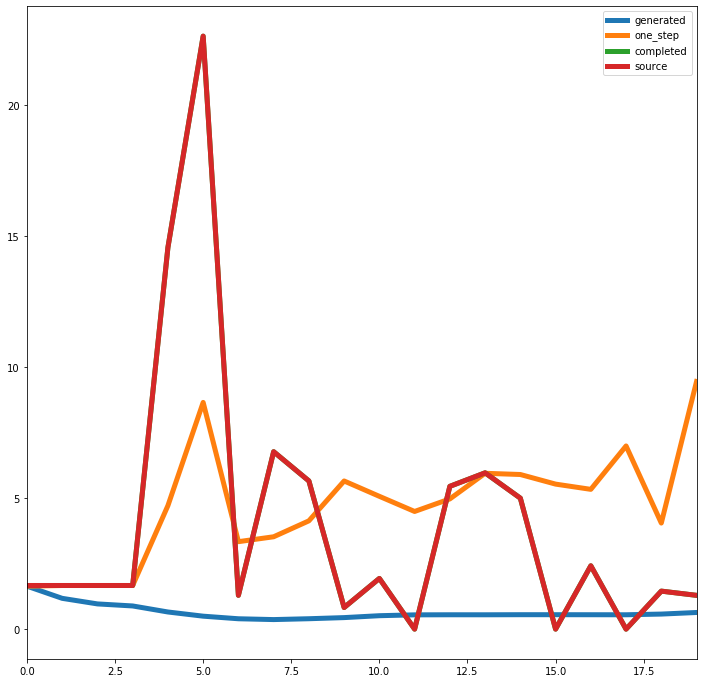

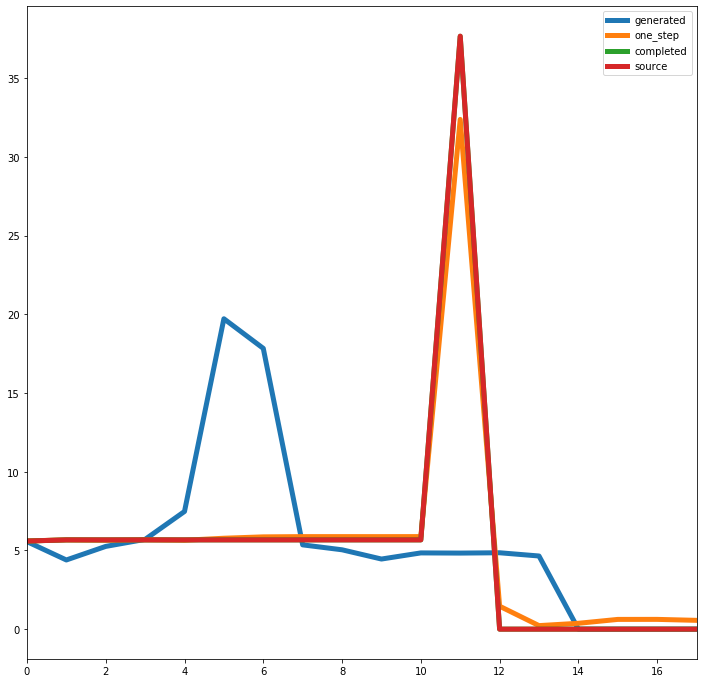

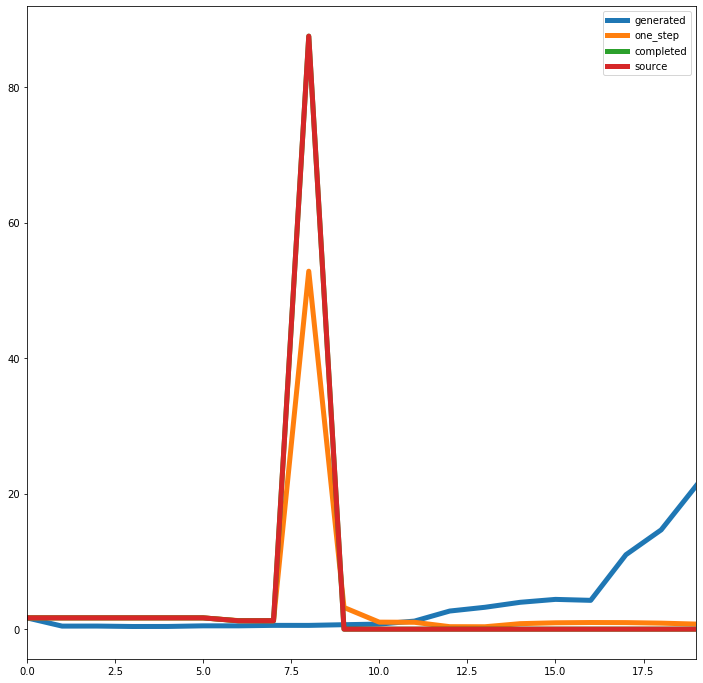

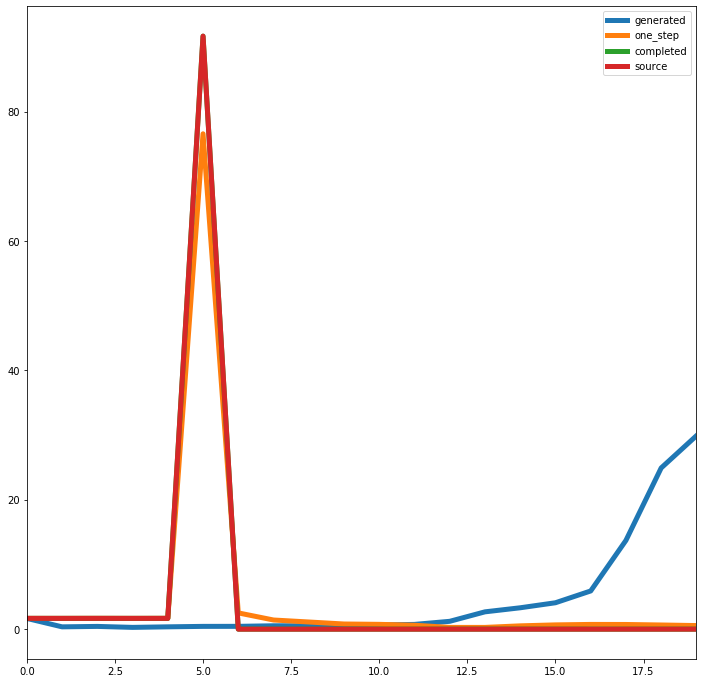

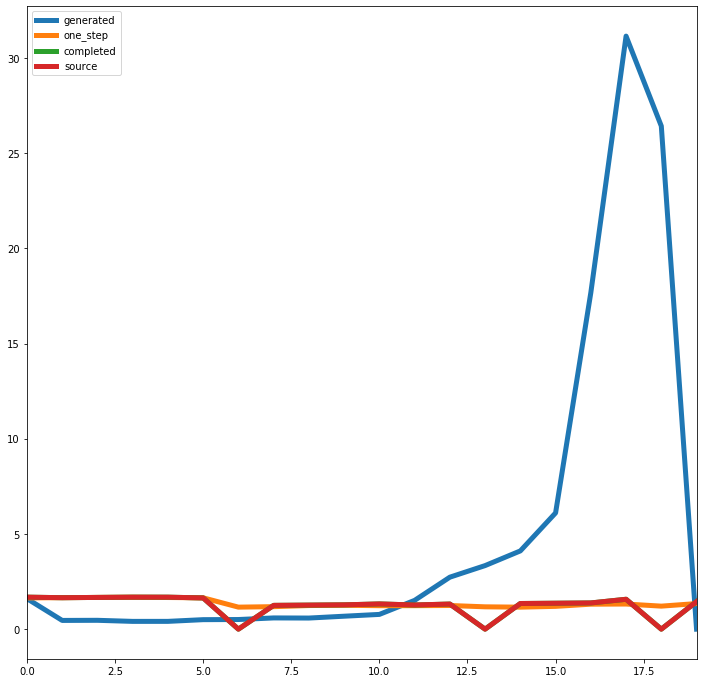

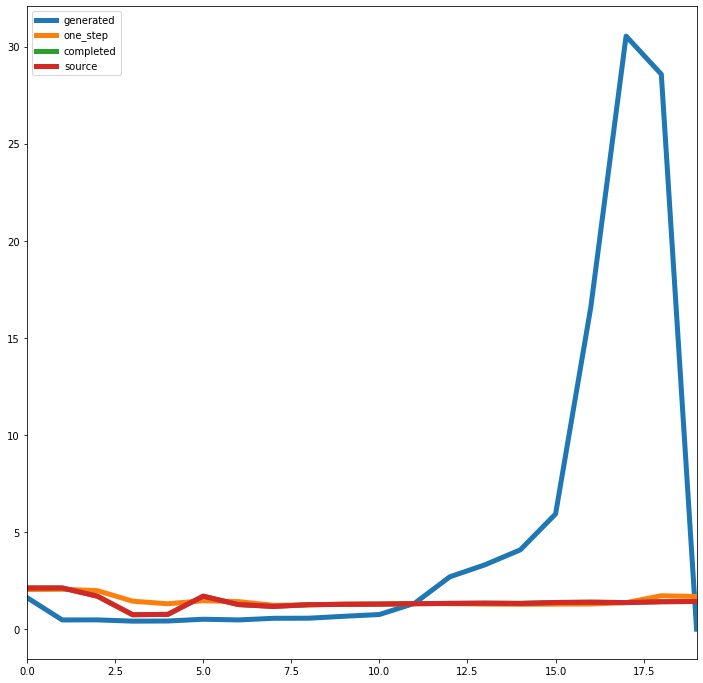

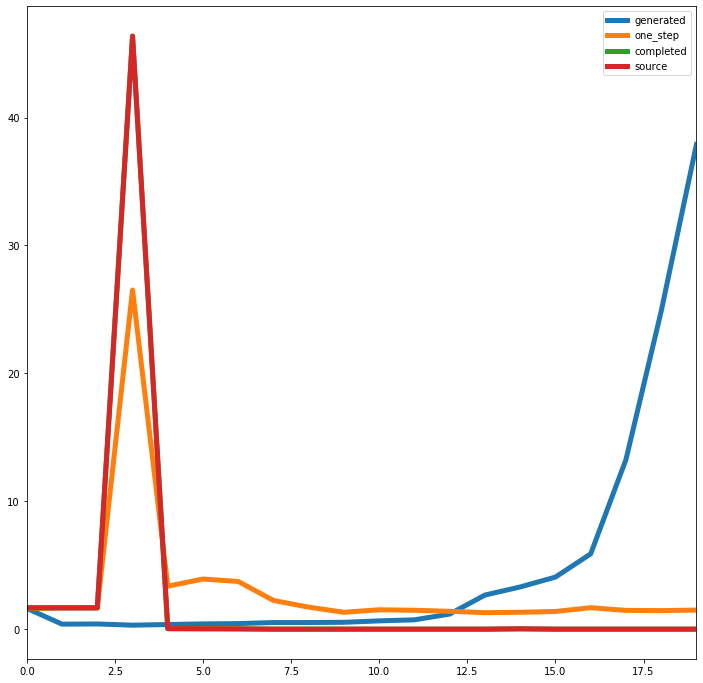

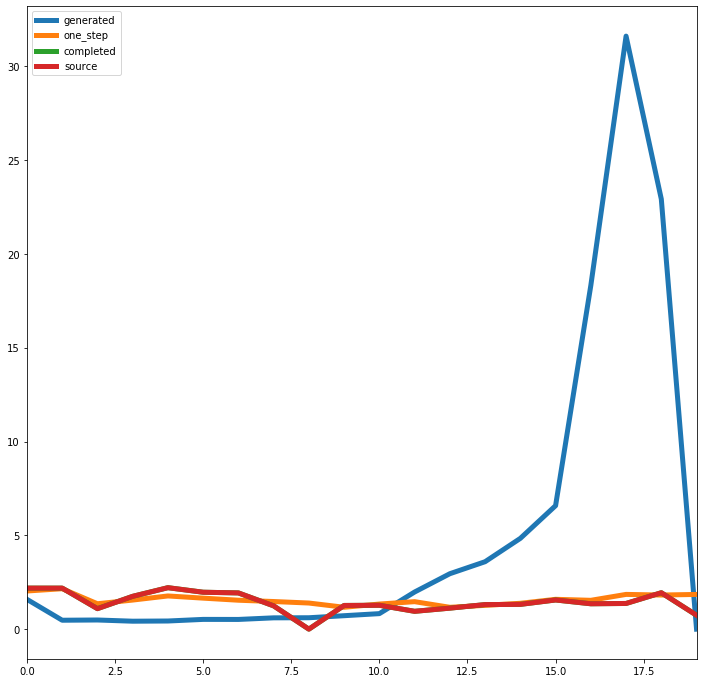

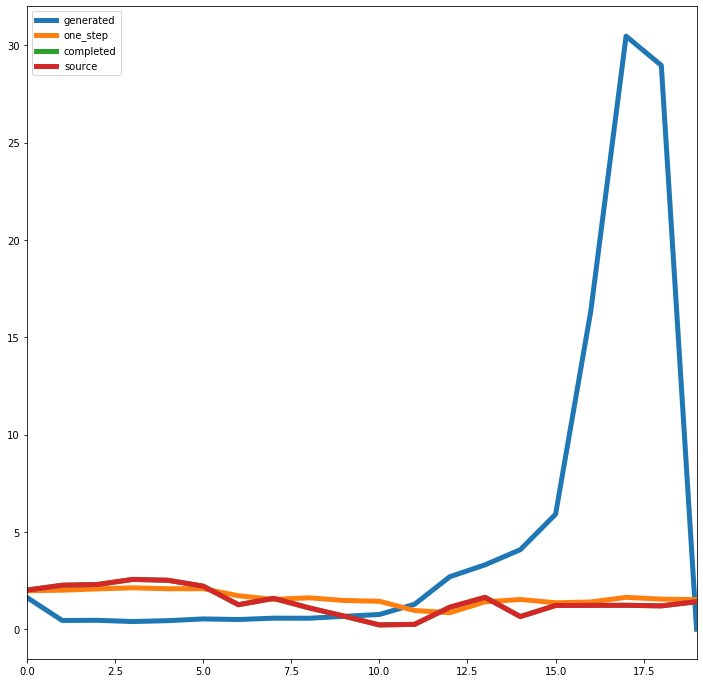

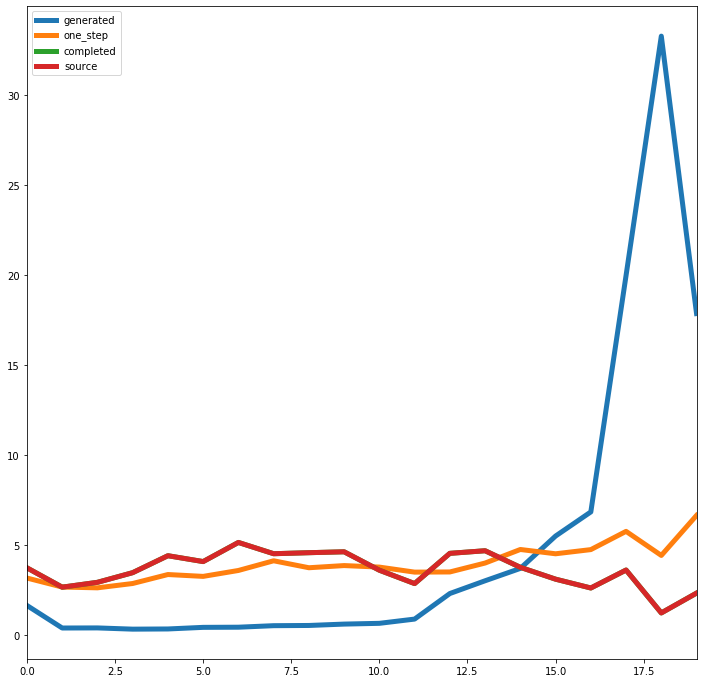

In [29]:
counter = 1
for key, df in data_final.groupby('CONTRACT_ID'):
    generated = generate_series(df)
    response_percent, one_step_response, src_percent = complete_series(df)
    df = pd.DataFrame.from_dict(OrderedDict({
        'generated' : np.array(generated)[:20],
        'one_step'  : np.array(one_step_response)[:20],
        'completed' : np.array(response_percent)[:20],
        'source'    : np.array(src_percent)[:20]
    }))
    df.plot(figsize=(12, 12), linewidth = 5)
    counter += 1
    if counter > 10:
        break